In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.linalg as la
import sympy as sp
from scipy.optimize import fsolve, newton
from scipy.integrate import solve_ivp

In [3]:
def EE(yn, f, tau, t=0):
    return yn + tau*f(yn,t)

def RK4(yn, f, tau, t=0):
    k1=f(yn,t)
    k2=f(yn+tau*k1/2,t)
    k3=f(yn+tau*k2/2,t)
    k4=f(yn+tau*k3,t)
    return yn+tau/6*(k1+2*k2+2*k3+k4)

# Rk módszerek tesztelése
Vizsgáljuk meg, hogy egyes RK módszerek milyen minőségben oldanak meg egyes merev rendszereket


## 0. példa: Dahlquist-féle tesztegyenlet, $\lambda=-1$
$$ \begin{cases}
y'(t)=-y(t) \\
y(0)=1
\end{cases}$$

In [3]:
def f0(y,t=0):
    return -y

tau=2.5
T=40
lepszam=int(np.ceil(T/tau))
t_ertekek=np.linspace(0, T, lepszam, endpoint=True)

t_pontos=np.linspace(0,T,lepszam*5,endpoint=True)
pontos=np.e**((-1)*t_pontos)

In [4]:
def IE0(yn, tau):
    return yn/(1+tau)

def trapez0(yn, tau):
    return yn*((1-tau*0.5)/(1+tau*0.5))

In [5]:
def feladat0(tau, T):
    lepszam=int(np.ceil(T/tau))
    #t_ertekek=np.linspace(0, T, lepszam, endpoint=True)
    t_ertekek=[i*tau for i in range(lepszam)]
    y=np.zeros((3,len(t_ertekek)))
    y[0,0], y[1,0], y[2,0] = 1, 1, 1

    for i in range(1,len(t_ertekek)):
        y[0,i]=EE(y[0,i-1],f0,tau)
        y[1,i]=IE0(y[2,i-1],tau)
        y[2,i]=trapez0(y[2,i-1],tau)

    return y, t_ertekek

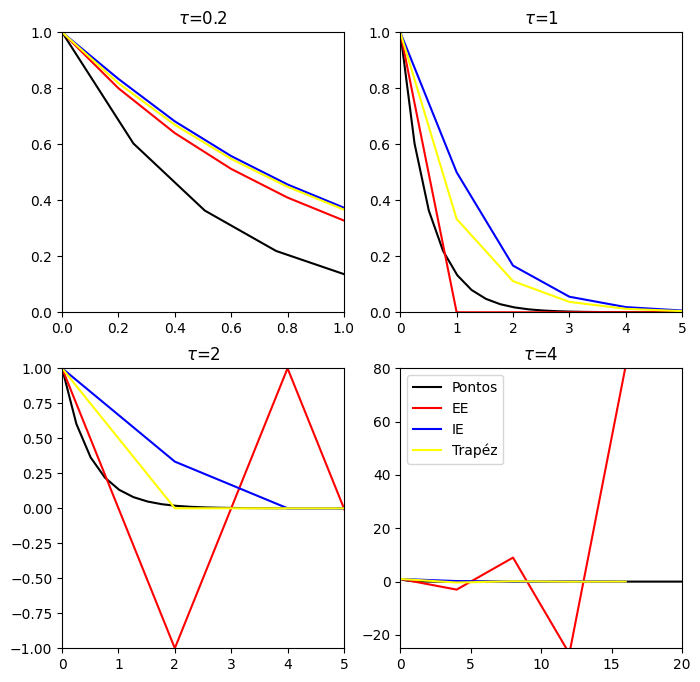

In [6]:
tauk=[0.2,1,2,4]
xlims=[1,5,5,16]
upylims=[1,1,1,80]
downylims=[0,0,-1,-25]
T=20
fig, ax= plt.subplots(nrows=2, ncols=2, figsize=(8,8))
plt.title(f"0. feladat")
it=0
for i in range(2):
    for j in range(2):
        P=feladat0(tauk[it],T)
        y=P[0]
        t=P[1]
        ax[i,j].set_title(r"$\tau$=" "{}".format(tauk[it]))
        ax[i,j].plot(np.linspace(0,T,lepszam*5,endpoint=True), pontos, color="black", label="Pontos")
        ax[i,j].plot(t, y[0,:], color="red", label="EE")
        ax[i,j].plot(t, y[1,:], color="blue", label="IE")
        ax[i,j].plot(t, y[2,:], color="yellow", label="Trapéz")
        ax[i,j].set_xlim([0,xlims[it]])
        ax[i,j].set_ylim(downylims[it],upylims[it])
        if it==3:
            ax[i,j].set_xlim([0,T])
        it+=1
plt.legend()
plt.show()

## 1. példa: 
$$ \begin{cases}
y'(t)=-15y(t) \\
y(0)=1
\end{cases}$$

In [174]:
def f1(y,t=0):
    return -15*y

tau=0.2
T=40
lepszam=int(np.ceil(T/tau))
t_ertekek=t_ertekek=[i*tau for i in range(lepszam)]

In [175]:
def IE1(yn, tau):
    return yn/(1+15*tau)

def trapez1(yn, tau):
    return yn*((1-tau*7.5)/(1+tau*7.5))

In [177]:
y=np.zeros((3,len(t_ertekek)))
y[0,0], y[1,0], y[2,0] = 1, 1, 1

for i in range(1,len(t_ertekek)):
    y[0,i]=EE(y[0,i-1],f1,tau)
    y[1,i]=IE1(y[2,i-1],tau)
    y[2,i]=trapez1(y[2,i-1],tau)

t_pontos=np.linspace(0,T,lepszam*5,endpoint=True)
pontos=np.e**((-15)*t_pontos)

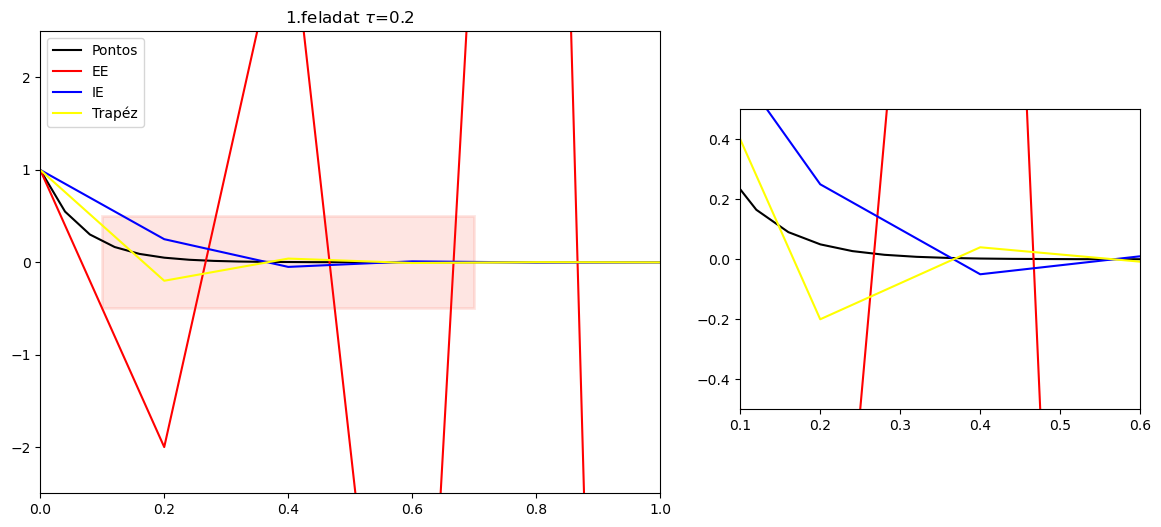

In [179]:
fig, ax = plt.subplots(figsize=(8,6))
plt.title(r"1.feladat $\tau$=" "{}".format(tau))
plt.plot(t_pontos, pontos, color="black", label="Pontos")
plt.plot(t_ertekek, y[0,:], color="red", label="EE")
plt.plot(t_ertekek, y[1,:], color="blue", label="IE")
plt.plot(t_ertekek, y[2,:], color="yellow", label="Trapéz")
ax.legend()
ax.set_xlim([0,1])
ax.set_ylim([-2.5,2.5])

left, bottom, width, height = (0.1, -0.5, 0.6, 1)
rect=mpatches.Rectangle((left,bottom),width,height,
                        color="salmon", alpha=0.2,
                       linewidth=2)
plt.gca().add_patch(rect)

ax2 = plt.axes([1, 0.25, 0.5, 0.5])

ax2.plot(t_pontos, pontos, color="black", label="Pontos")
ax2.plot(t_ertekek, y[0,:], color="red", label="EE")
ax2.plot(t_ertekek, y[1,:], color="blue", label="IE")
ax2.plot(t_ertekek, y[2,:], color="yellow", label="Trapéz")

ax2.set_xlim([0.1,0.6])
ax2.set_ylim([-0.5,0.5])




plt.show()


## 2. példa: Harmonikus rezgőmozgás

$$ x''(t)=-\omega^2x(t)$$

$$\begin{cases}
x'(t)=v(t) \\
v'(t)=-\omega^2x(t)
\end{cases}$$

Legyen $\omega=1$

In [72]:
def f2(y,t):
    return  np.array([y[1],-y[0]])

def IE2(y, tau):
    x=y[0]/(1+tau**2)+tau*y[1]/(1+tau**2)
    v=(1-tau**2/(1+tau**2))*y[1]-tau*y[0]/(1+tau**2)
    return np.array([x,v])

def trapez2(y, tau):
    x=y[0]*(1-tau**2/4)/(1+tau**2/4)+y[1]*(tau/(1+tau**2/4))
    v=y[1]-y[0]*tau/2-x*tau/2
    return np.array([x,v])

In [73]:
tau=0.1
T=20
lepszam=int(np.ceil(T/tau))
t_ertekek=[i*tau for i in range(lepszam)]

yEE=np.zeros((2,lepszam))
yIE=np.zeros((2,lepszam))
yTR=np.zeros((2,lepszam))

yEE[:,0], yIE[:,0], yTR[:,0] = [1,0], [1,0], [1,0]

for i in range(1,lepszam):
    yEE[:,i]=EE(yEE[:,i-1],f2,tau)
    yIE[:,i]=IE2(yIE[:,i-1],tau)
    yTR[:,i]=trapez2(yTR[:,i-1],tau)

x=0
y=0
r=1
theta=np.linspace(0,2*np.pi, 500)
x = x + r * np.cos(theta)
y = y + r * np.sin(theta)

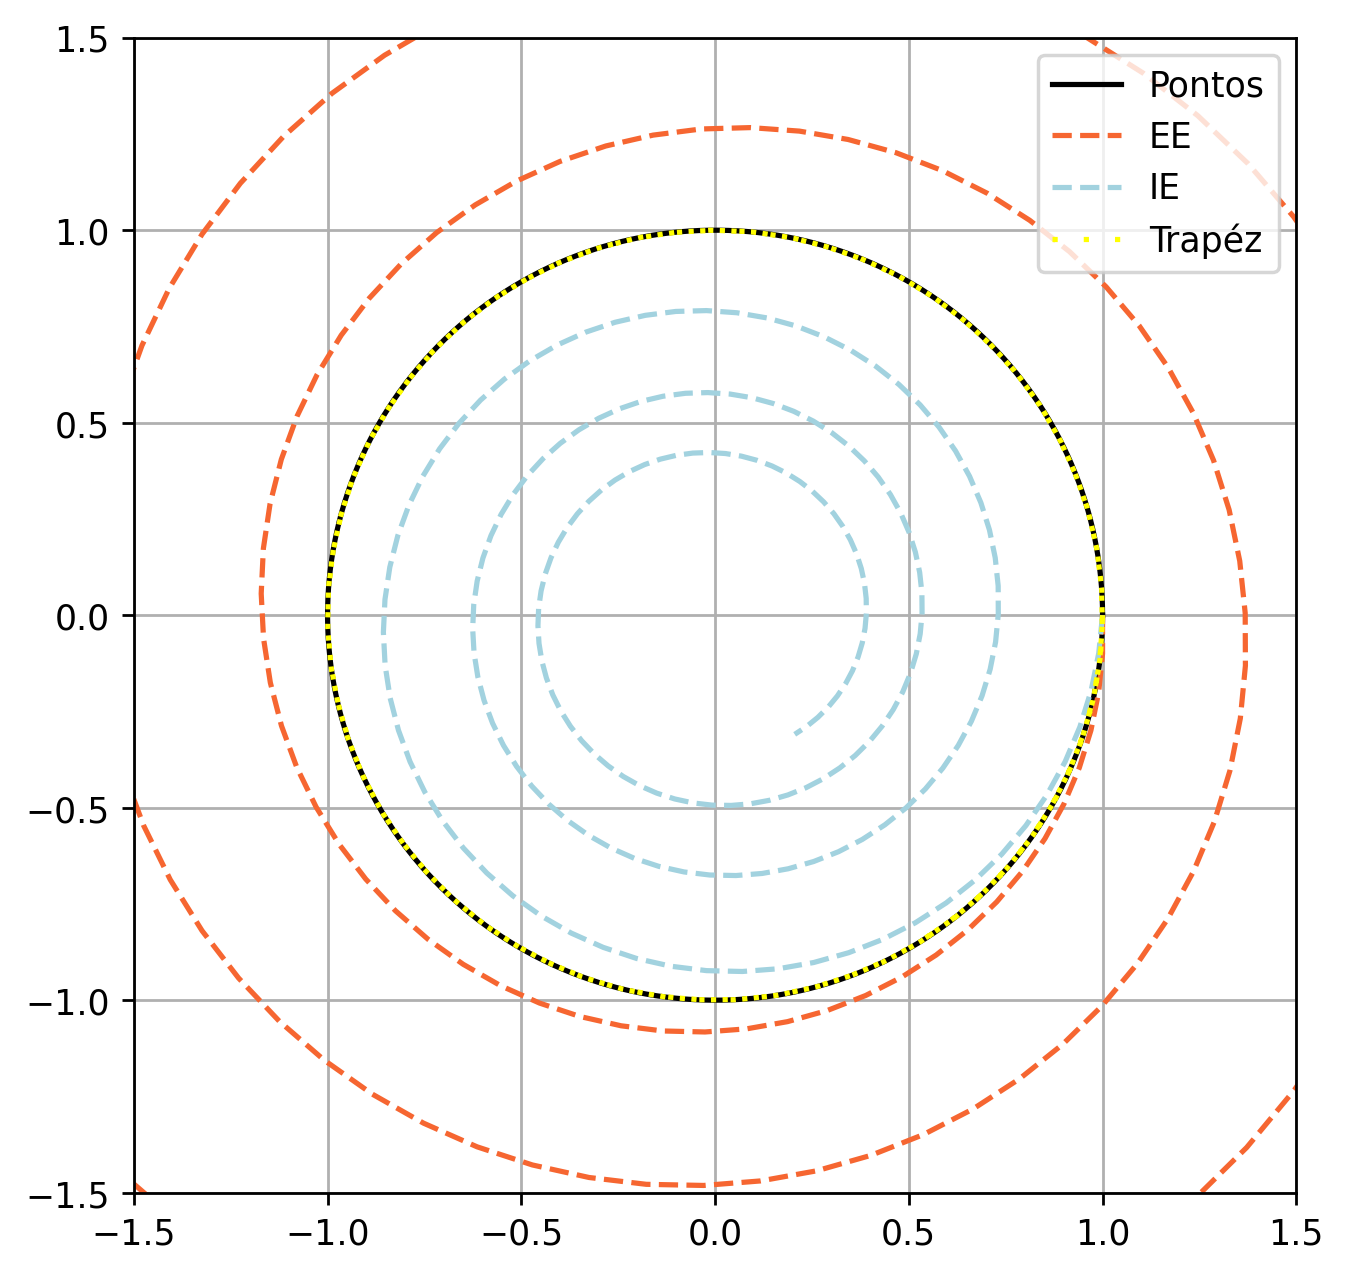

In [74]:
fig, ax = plt.subplots(figsize=(6,6), dpi=250)
a=1.5
plt.plot(x,y, color="black", label="Pontos")
plt.plot(yEE[0,:],yEE[1,:], color="#f66631", linestyle="--", label="EE")
plt.plot(yIE[0,:],yIE[1,:], color="#A2D2DF", linestyle="--", label="IE")
plt.plot(yTR[0,:],yTR[1,:], color="yellow", linestyle=(0, (1, 5)), label="Trapéz")
plt.legend(loc="upper right")
plt.grid(True)
plt.xlim(-a,a)
plt.ylim(-a,a)

plt.show()


## 3. példa 

$$x'(t)=-50(x(t)-\cos{t})$$

In [2]:
def abra_3(IV):
    t=np.linspace(0,1.5,1000)
    def fv(x,iv):
        return (iv-2500/2501)*np.exp(-50*x)+2500/2501*np.cos(x)+50/2501*np.sin(x)

    fig = plt.subplots(figsize=(6,6),dpi=200)

    for iv in IV:
        plt.plot(t,fv(t,iv), c="#003366", linewidth=1, alpha=0.8)
    plt.xticks([0,1])
    plt.yticks([1])
    plt.xlim(0,1.5)
    plt.ylim(0,1.5)

    #IE y_0=0-ra
    T=2
    tau=0.5
    t2=[0+tau*i for i in range(int(np.ceil(T/tau)+1))]
    y=[0]*(len(t2)-1)
    for i in range(1,len(y)):
        y[i]=(y[i-1]+50*tau*np.cos(t2[i]))/(1+50*tau)

    plt.plot(t2[:len(y)],y, linestyle="--", marker="o", c="#0066CC", label=r"IE, $\tau=$"+f"{tau}")
    plt.legend()
    plt.show()

    return

In [3]:
IV=[1-np.exp(i) for i in range(0,100)]+[0+np.exp(i) for i in range(1,100)]
IV

[0.0,
 -1.718281828459045,
 -6.38905609893065,
 -19.085536923187668,
 -53.598150033144236,
 -147.4131591025766,
 -402.4287934927351,
 -1095.6331584284585,
 -2979.9579870417283,
 -8102.083927575384,
 -22025.465794806718,
 -59873.14171519782,
 -162753.79141900392,
 -442412.3920089205,
 -1202603.2841647768,
 -3269016.3724721107,
 -8886109.520507872,
 -24154951.7535753,
 -65659968.13733051,
 -178482299.96318725,
 -485165194.4097903,
 -1318815733.4832146,
 -3584912845.131592,
 -9744803445.248903,
 -26489122128.84347,
 -72004899336.38588,
 -195729609427.83878,
 -532048240600.7986,
 -1446257064290.475,
 -3931334297143.042,
 -10686474581523.463,
 -29048849665246.426,
 -78962960182679.69,
 -214643579785915.06,
 -583461742527453.9,
 -1586013452313429.8,
 -4311231547115194.0,
 -1.1719142372802612e+16,
 -3.1855931757113756e+16,
 -8.659340042399374e+16,
 -2.3538526683702e+17,
 -6.398434935300549e+17,
 -1.739274941520501e+18,
 -4.727839468229346e+18,
 -1.2851600114359308e+19,
 -3.4934271057485095e+1

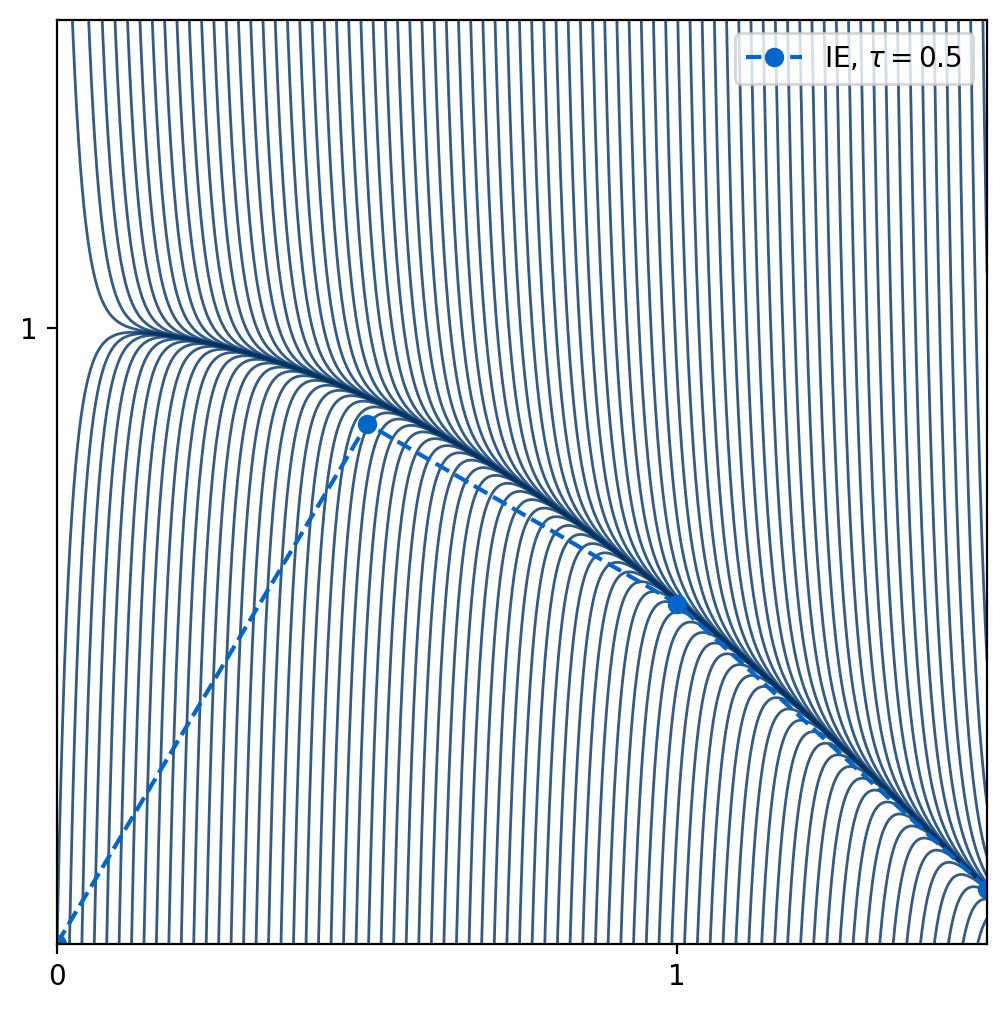

In [4]:
abra_3(IV)

In [10]:
def abra_3_EE(tau1,tau2):
    T=2
    t1=[0+tau1*i for i in range(int(np.ceil(T/tau1)))]
    t2=[0+tau2*i for i in range(int(np.ceil(T/tau2)))]
    y1=[0]*(len(t1))
    y2=[0]*(len(t2))
    for i in range(1,len(y1)):
        y1[i]=(1-50*tau1)*y1[i-1]+50*tau1*np.cos(t1[i])   
    for i in range(1,len(y2)):
        y2[i]=(1-50*tau2)*y2[i-1]+50*tau2*np.cos(t2[i])  

    fig = plt.subplots(figsize=(6,6),dpi=200)
    
    plt.plot(t1,y1, linestyle="-", marker="o", c="#003366", label=r"EE, $\tau=$"+f"{tau1}", linewidth=1, markersize=5)
    plt.plot(t2,y2, linestyle="-", marker="o", c="#0066CC", label=r"EE, $\tau=$"+f"{tau2}", linewidth=1, markersize=5)
    plt.xticks([0,1])
    plt.yticks([1])
    plt.xlim(0,1.5)
    plt.ylim(0,1.5)
    plt.legend()
    plt.show()
    return


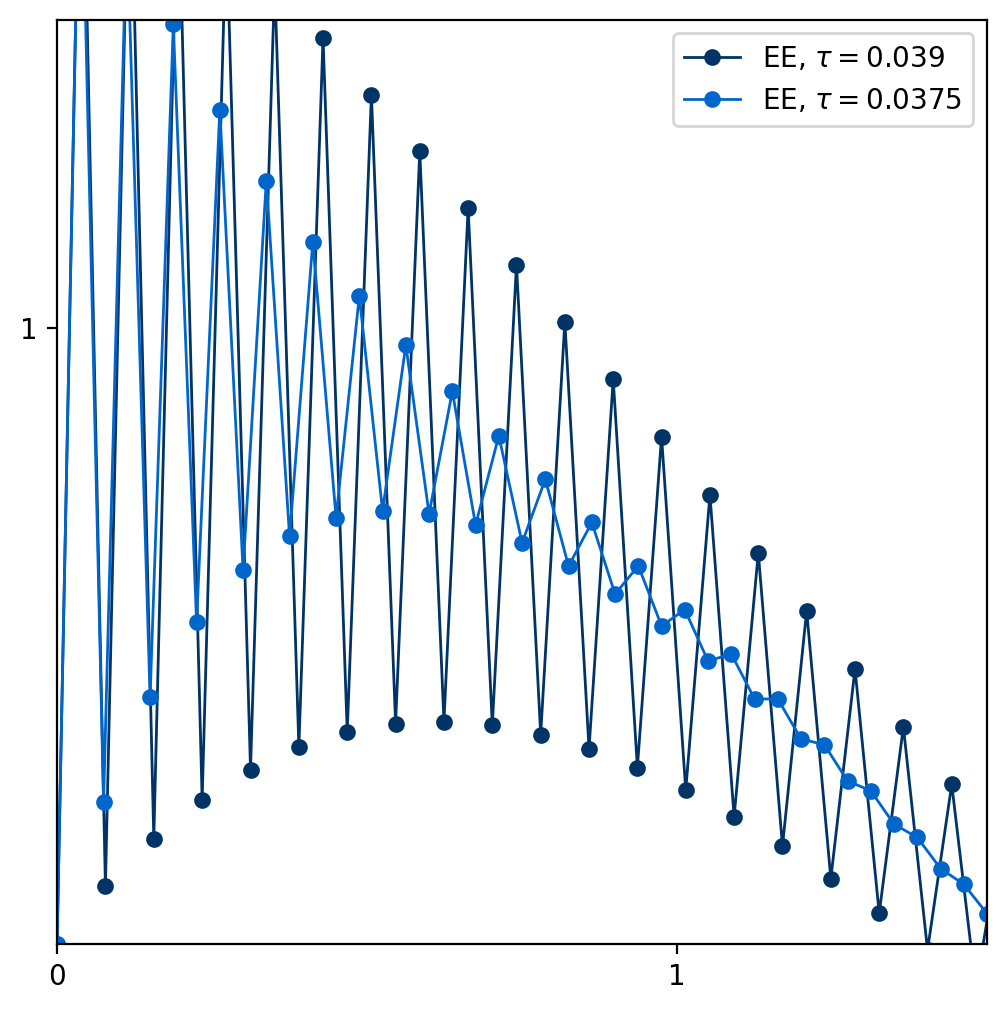

In [13]:
abra_3_EE(0.039,1.875/50)

## 4. példa: Áramkörök

\begin{aligned}
    x'(t)={}&y(t) \qquad &&x(0)=2\\
    y'(t)={}&\mu\Big(1-x^2(t)\Big)y(t)-x(t) \qquad &&y(0)=0
\end{aligned}


In [ ]:
def abra_4_fazister(x_max,y_max,tau,mu,T):
    def aramkor(yn,t=0):
        return np.array([yn[1],mu*(1-yn[0]**2)*yn[1]-yn[0]])

    lepszam=int(np.ceil(T/tau))
    t_ertekek=np.array([i*tau for i in range(lepszam)])
    yRK=np.zeros((2,lepszam))
    yRK[:,0]=[2,0]
    for i in range(1,lepszam):
        k1=aramkor(yRK[:,i-1],mu)
        k2=aramkor(yRK[:,i-1]+tau*k1/2,mu)
        k3=aramkor(yRK[:,i-1]+tau*k2/2,mu)
        k4=aramkor(yRK[:,i-1]+tau*k3,mu)
        yRK[:,i]=yRK[:,i-1]+tau/6*(k1+2*k2+2*k3+k4)

    val_max=np.max(abs(yRK[1,:]))+1

    x = np.linspace(-x_max, x_max, 250)
    y = np.linspace(-val_max, val_max, 250)
    y1, y2 = np.meshgrid(x, y)

    y1dot = y2
    y2dot = mu*(1-y1**2)*y2-y1

    fig, ax = plt.subplots(figsize=(6,6), dpi=250)
    plt.streamplot(y1, y2, y1dot, y2dot, color="#003366", linewidth=1, density=1, broken_streamlines=False)
    plt.plot(yRK[0,:],yRK[1,:], color="#0066CC", label=r"RK4, $\tau=$"+f"{tau}")
    plt.legend(fontsize=10)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-x_max,x_max)
    plt.ylim(-val_max,val_max)
    ax.set_aspect("equal")
    plt.tight_layout()
    plt.title(r"$\mu=$"+f"{mu}")
    plt.show()

    fig, ax = plt.subplots(figsize=(12,3),dpi=200)

    plt.plot(t_ertekek,yRK[0,:],color="#0066CC", label=r"RK4, $\tau=$"+f"{tau}")
    plt.xlim(0,T)
    plt.show()


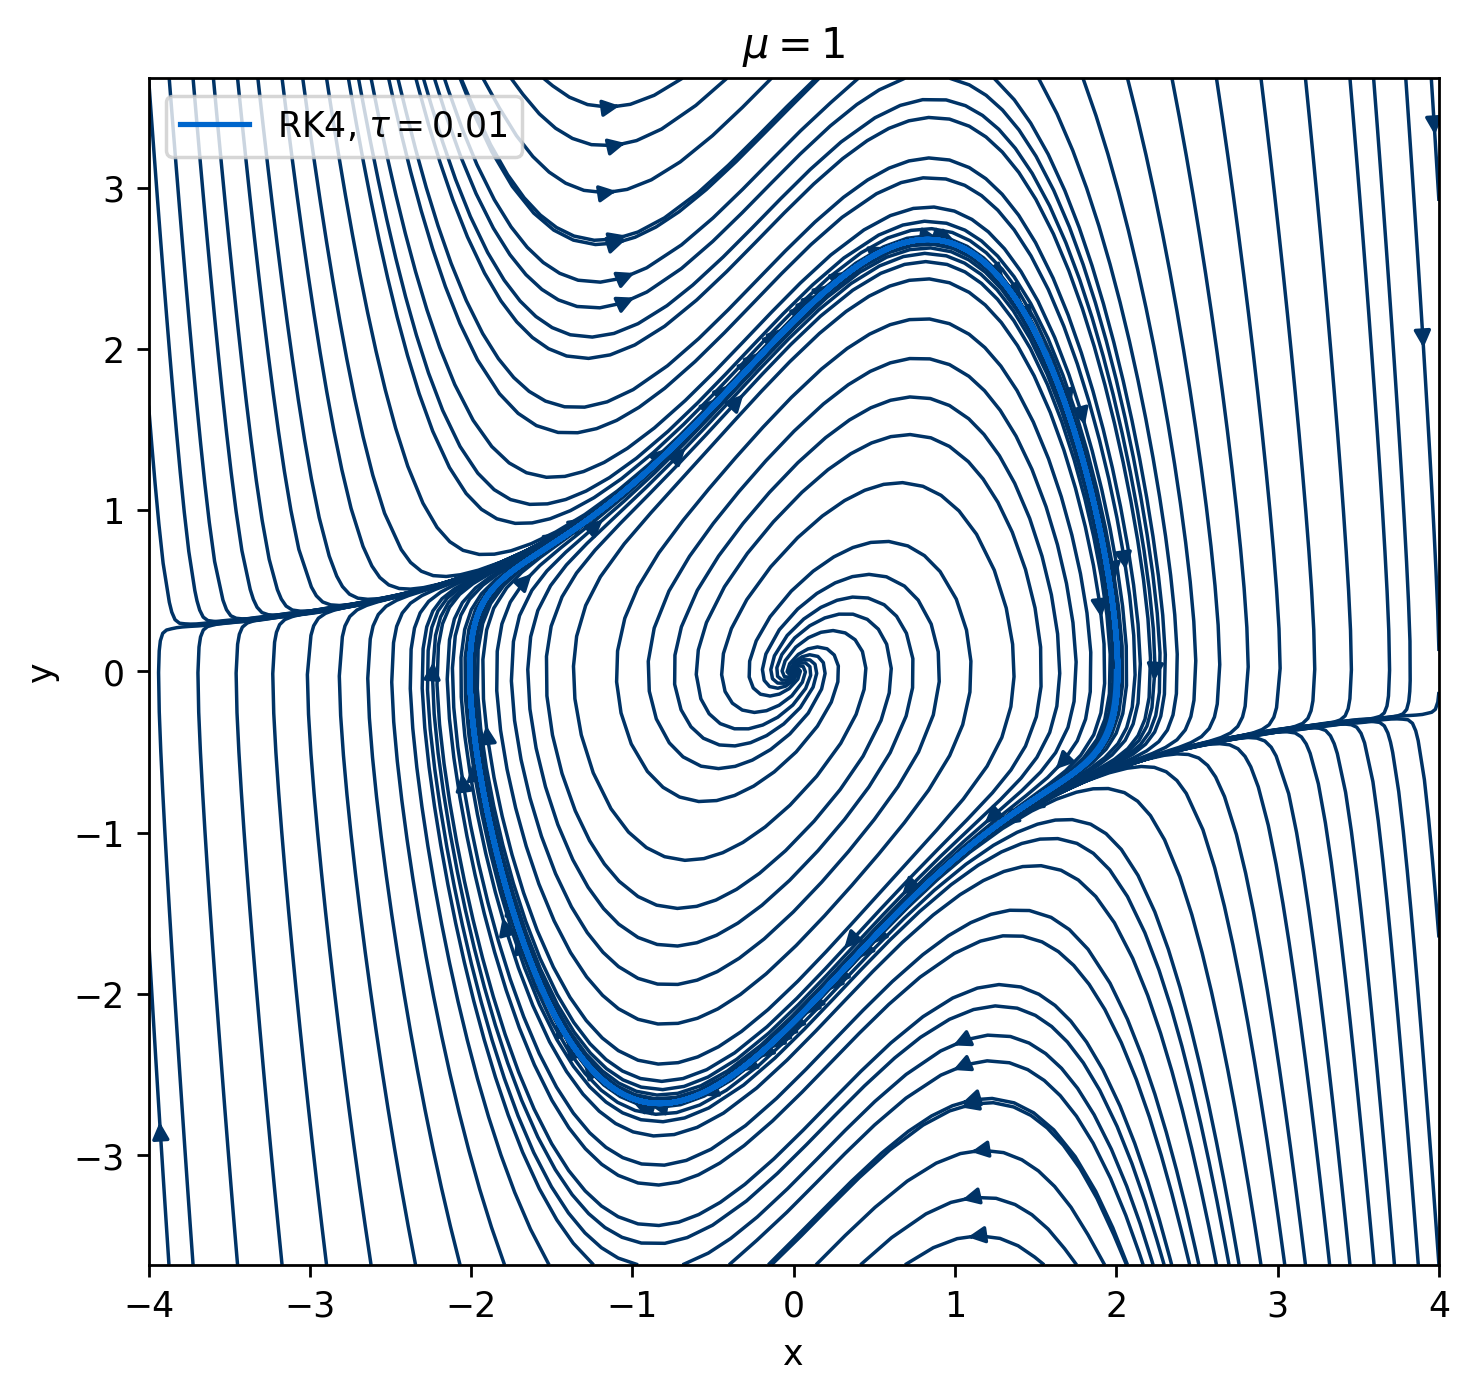

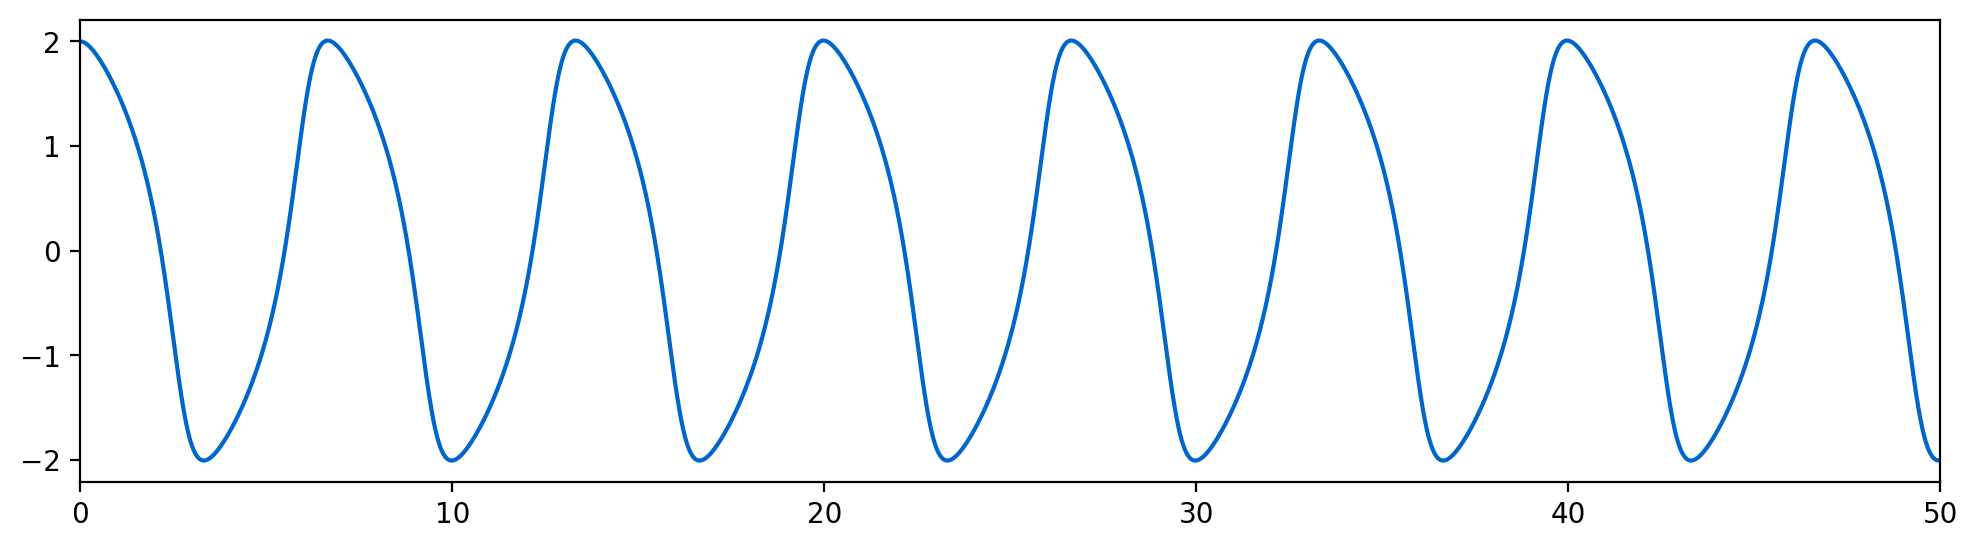

In [167]:
abra_4_fazister(4,4,0.01,1,50)

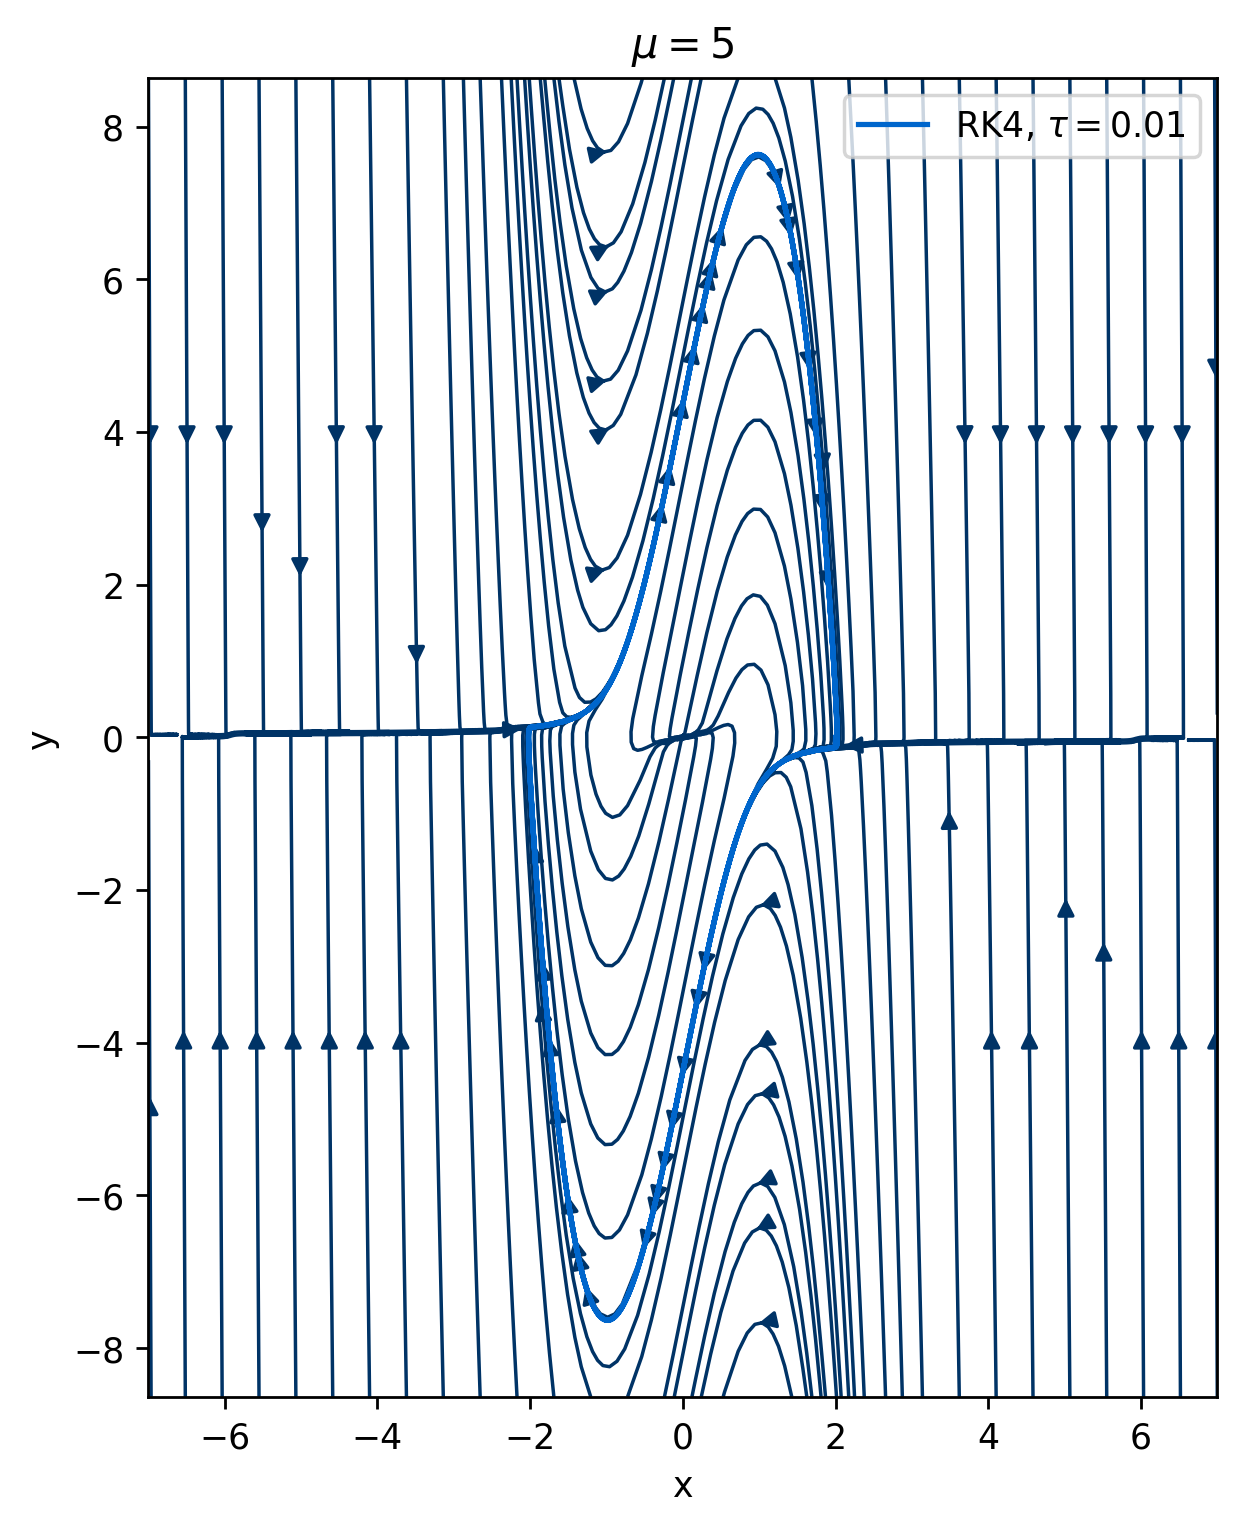

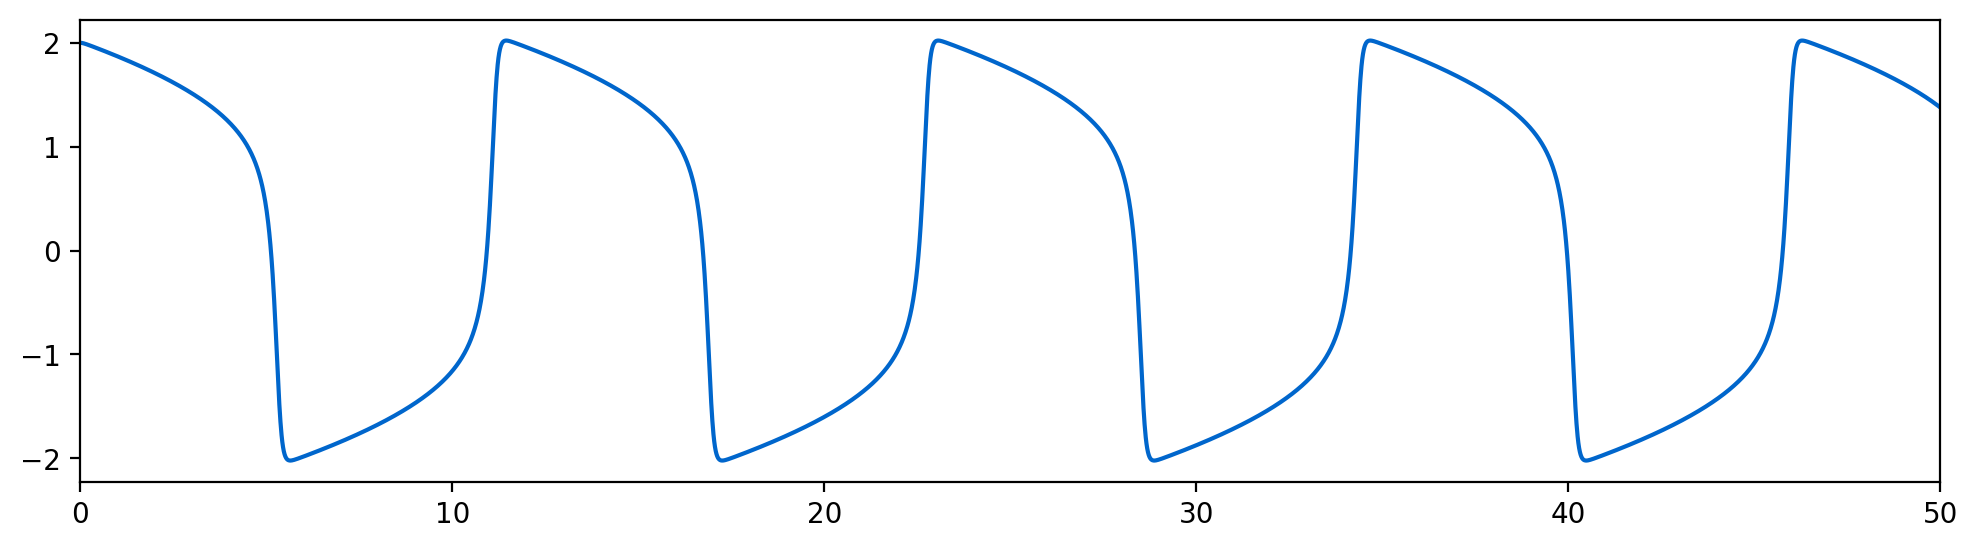

In [168]:
abra_4_fazister(7,4,0.01,5,50)

In [3]:
def abra_4_2(mu,tau,T):
    def aramkor(yn,mu,t=0):
        return np.array([yn[1],mu*(1-yn[0]**2)*yn[1]-yn[0]])

    lepszam=int(np.ceil(T/tau))
    t_ertekek=np.array([i*tau for i in range(lepszam)])
    yRK=np.zeros((2,lepszam))
    yRK[:,0]=[2,0]
    yRK2=np.zeros((2,lepszam))
    yRK2[:,0]=[2,0]
    for i in range(1,lepszam):
        k1=aramkor(yRK[:,i-1],mu)
        k2=aramkor(yRK[:,i-1]+tau*k1/2,mu)
        k3=aramkor(yRK[:,i-1]+tau*k2/2,mu)
        k4=aramkor(yRK[:,i-1]+tau*k3,mu)
        yRK[:,i]=yRK[:,i-1]+tau/6*(k1+2*k2+2*k3+k4)
    '''for i in range(1,lepszam):
        yRK2[:,i]=yRK2[:,i-1]+tau*aramkor(yRK2[:,i-1],mu)'''
    
    fig, ax = plt.subplots(figsize=(10,5),dpi=150)
    plt.plot(yRK[0,:], yRK[1,:], linewidth=1)
    plt.scatter(yRK[0,:], yRK[1,:], s=1)
    '''plt.plot(yRK2[0,:], yRK2[1,:], linewidth=1, linestyle="--")
    plt.scatter(yRK2[0,:], yRK2[1,:], s=1)'''
    
    plt.show()
    print(t_ertekek[-1])

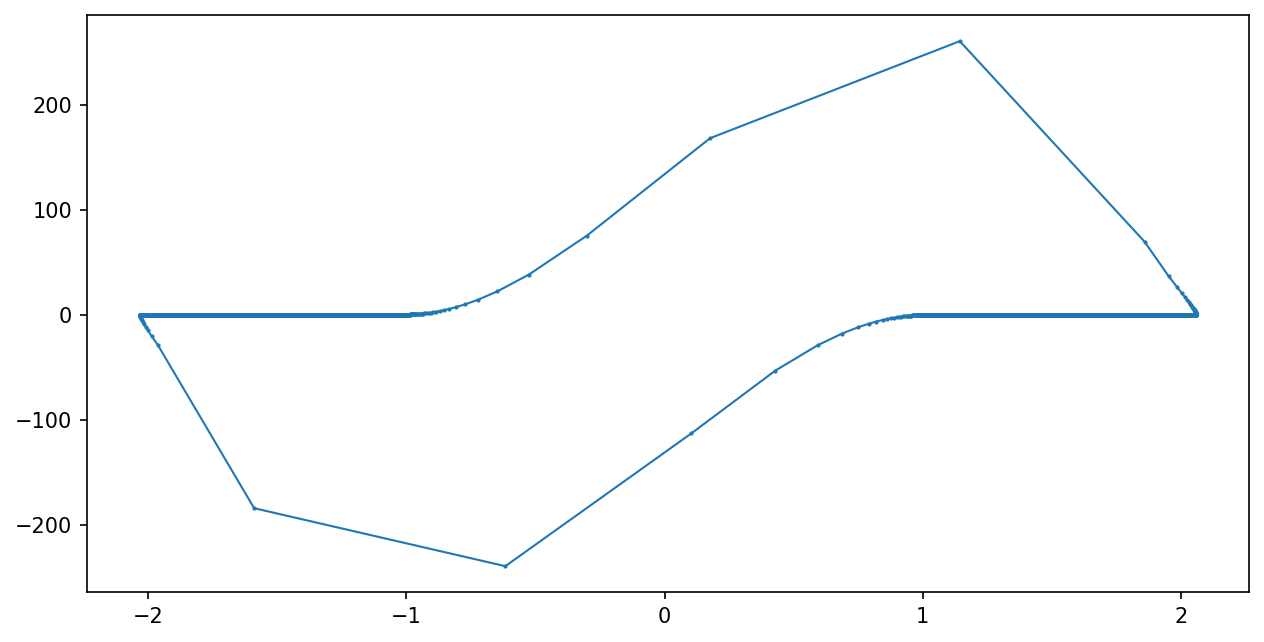

499.99620999999996


In [17]:
abra_4_2(200,0.004154,500)

### IE módszerrel

In [18]:
def abra_4_IE(mu,tau,T):
    def aramkor(yn,mu,t=0):
        return np.array([yn[1],mu*(1-yn[0]**2)*yn[1]-yn[0]])
    
    def IE_aramkor(f,y,tau,mu,t=0):
        '''y_new=y
        for _ in range(5):
            F = y_new - y - tau * f(y_new, mu)
            J = np.array([[1, -tau], 
                          [tau * (2 * mu * y_new[0] * y_new[1] + 1), 1 - tau * mu * (1 - y_new[0]**2)]])
            delta_y = np.linalg.solve(J, F)
            y_new -= delta_y
        return y_new'''
    
        def residual(y_new): # Gyökkeresős függvény
            y_new = np.asarray(y_new)  
            return y_new - y - tau * f(y_new, mu)
        
        # Kezdeti tipp EE lépéssel
        y_guess = np.asarray(y) + tau * f(y, mu)
        
        # Scipy fsolve megoldó
        y_new = newton(residual, y_guess, maxiter=1000)
        return y_new
    
    lepszam=int(np.ceil(T/tau))
    t_ertekek=np.array([i*tau for i in range(lepszam)])
    yIE=np.zeros((2,lepszam))
    yIE[:,0]=np.array([2,0])

    for i in range(1,lepszam):
        yIE[:,i]=IE_aramkor(aramkor,yIE[:,i-1],tau,mu)
    
    fig, ax = plt.subplots(figsize=(6,6), dpi=200)
    plt.plot(yIE[0,:],yIE[1,:], color="#0066CC")
    plt.scatter(yIE[0,:],yIE[1,:], color="#0066CC", s=3)
    plt.grid()
    plt.show()
    print(t_ertekek[-1])
    return    

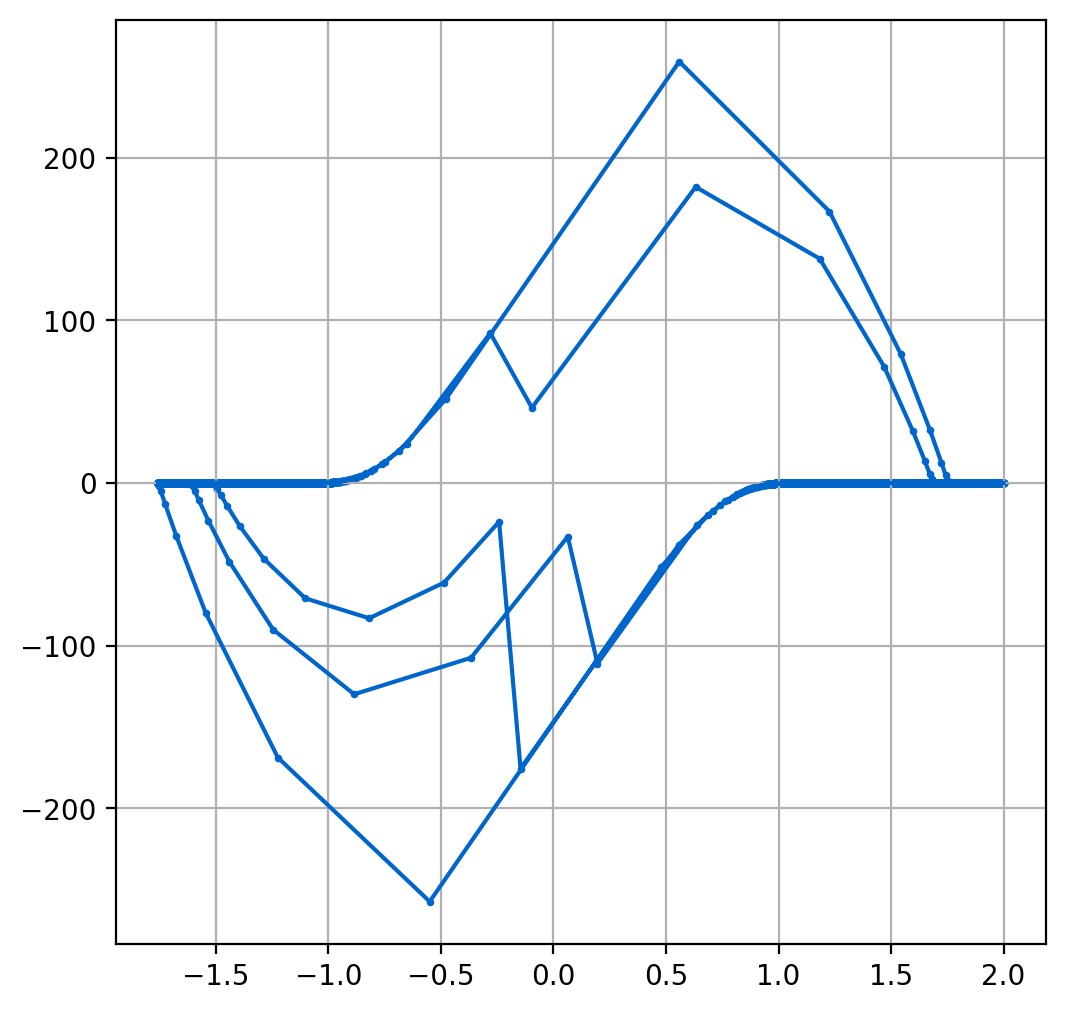

499.99600000000004


In [28]:
abra_4_IE(200,0.004,500)

### EE, RK4, IE együtt


In [2]:
def abra_4_3(mu,tauEE,tauRK4,tauIE,T):
    def aramkor(yn,mu,t=0):
        return np.array([yn[1],mu*(1-yn[0]**2)*yn[1]-yn[0]])
    
    def IE_aramkor(f,y,tau,mu,t=0):
        def residual(y_new): # Gyökkeresős függvény
            y_new = np.asarray(y_new)  
            return y_new - y - tau * f(y_new, mu)
        
        # Kezdeti tipp EE lépéssel
        y_guess = np.asarray(y) + tau * f(y, mu)
        
        # Scipy newton megoldó
        y_new = newton(residual, y_guess, maxiter=1000) # iterálva megkeresi a gyököt, (nem tökéletes)
        return y_new
    
    lepszam1=int(np.ceil(T/tauEE))
    t_ertekek1=np.array([i*tauEE for i in range(lepszam1)])
    yEE=np.zeros((2,lepszam1))
    yEE[:,0]=np.array([2,0])

    lepszam2=int(np.ceil(T/tauRK4))
    t_ertekek2=np.array([i*tauRK4 for i in range(lepszam2)])
    yRK4=np.zeros((2,lepszam2))
    yRK4[:,0]=np.array([2,0])

    lepszam3=int(np.ceil(T/tauIE))
    t_ertekek3=np.array([i*tauIE for i in range(lepszam3)])
    yIE=np.zeros((2,lepszam3))
    yIE[:,0]=np.array([2,0])

    for i in range(1,lepszam1):
        yEE[:,i]=yEE[:,i-1]+tauEE*aramkor(yEE[:,i-1],mu)

    for i in range(1,lepszam2):
        k1=aramkor(yRK4[:,i-1],mu)
        k2=aramkor(yRK4[:,i-1]+tauRK4*k1/2,mu)
        k3=aramkor(yRK4[:,i-1]+tauRK4*k2/2,mu)
        k4=aramkor(yRK4[:,i-1]+tauRK4*k3,mu)
        yRK4[:,i]=yRK4[:,i-1]+tauRK4/6*(k1+2*k2+2*k3+k4)

    for i in range(1,lepszam3):
        yIE[:,i]=IE_aramkor(aramkor,yIE[:,i-1],tauIE,mu)    

    fig, ax = plt.subplots(figsize=(6,6), dpi=200)
    plt.plot(yRK4[0,:], yRK4[1,:], color="#003366", linewidth=1, label=f"RK4, "+r"$\tau=$"+f"{tauRK4}")
    #plt.scatter(yRK4[0,:], yRK4[1,:], s=1)
    plt.plot(yEE[0,:], yEE[1,:], linewidth=1, linestyle="--", label=f"EE, "+r"$\tau=$"+f"{tauEE}")
    #plt.scatter(yEE[0,:], yEE[1,:], s=1)
    plt.plot(yIE[0,:],yIE[1,:], color="#0066CC", label=f"IE, "+r"$\tau=$"+f"{tauIE}")
    #plt.scatter(yEE[0,:], yEE[1,:], s=1)
    plt.grid()
    plt.tight_layout()
    plt.title(r"$\mu=$"+f"{mu}")
    plt.legend()
    plt.show()

    fig, ax = plt.subplots(figsize=(12,5), dpi=200)
    plt.plot(t_ertekek2, yRK4[0,:], color="#003366", linewidth=1, label=f"RK4, "+r"$\tau=$"+f"{tauRK4}")
    plt.plot(t_ertekek1, yEE[0,:], linewidth=1, linestyle="--", label=f"EE, "+r"$\tau=$"+f"{tauEE}")
    plt.plot(t_ertekek3, yIE[0,:], color="#0066CC", label=f"IE, "+r"$\tau=$"+f"{tauIE}")
    plt.grid()
    plt.tight_layout()
    plt.title(r"$\mu=$"+f"{mu}")
    plt.legend(fontsize=7)
    plt.show()

    return


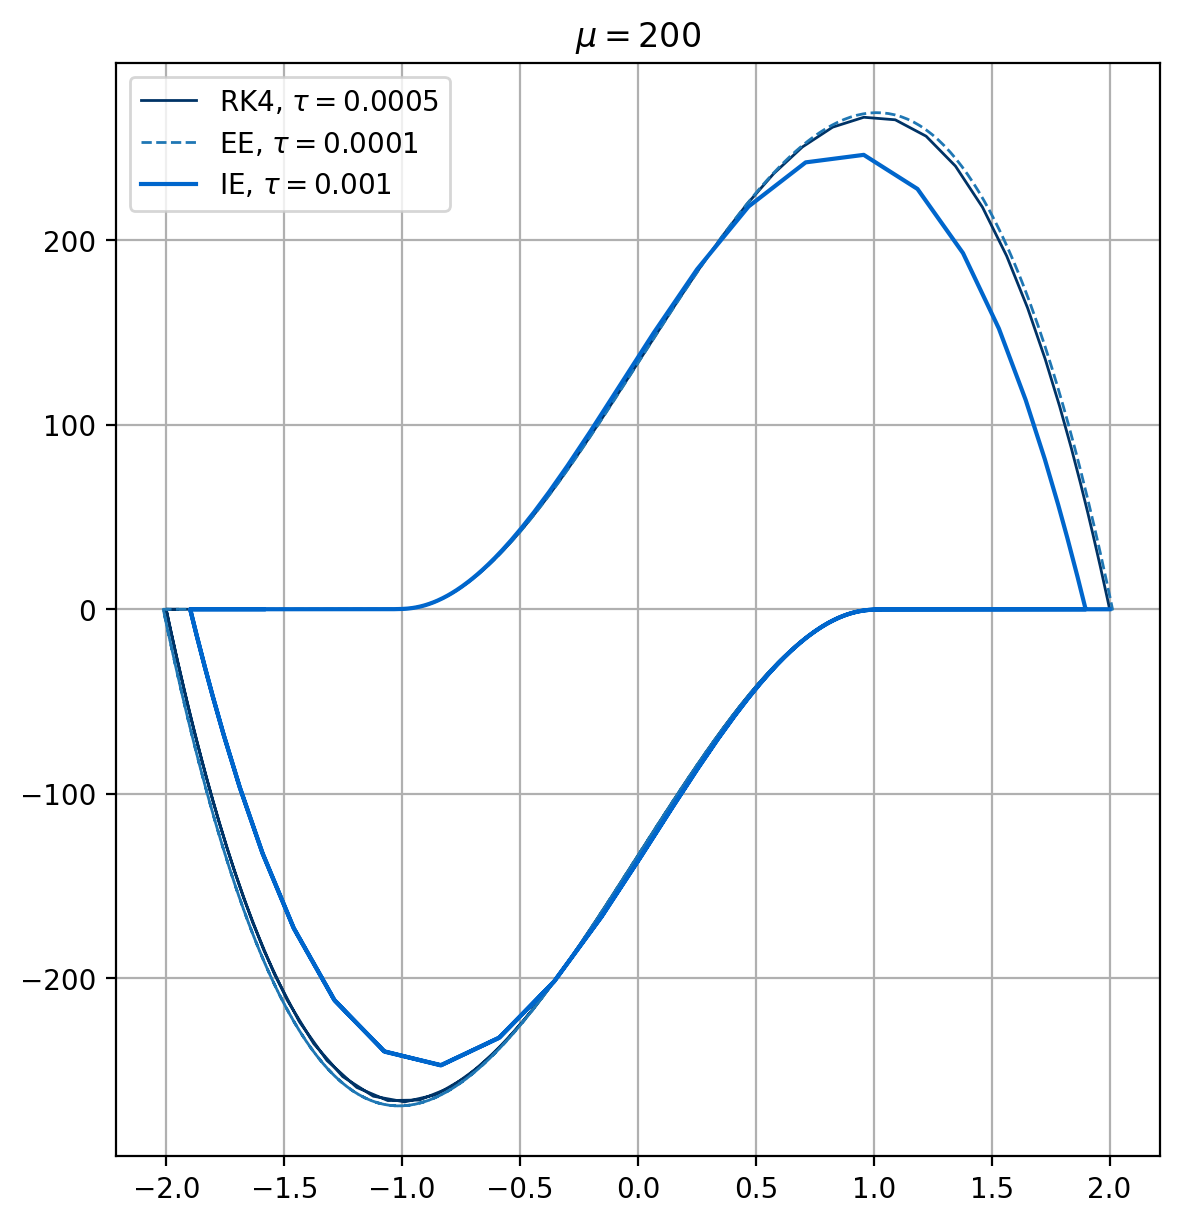

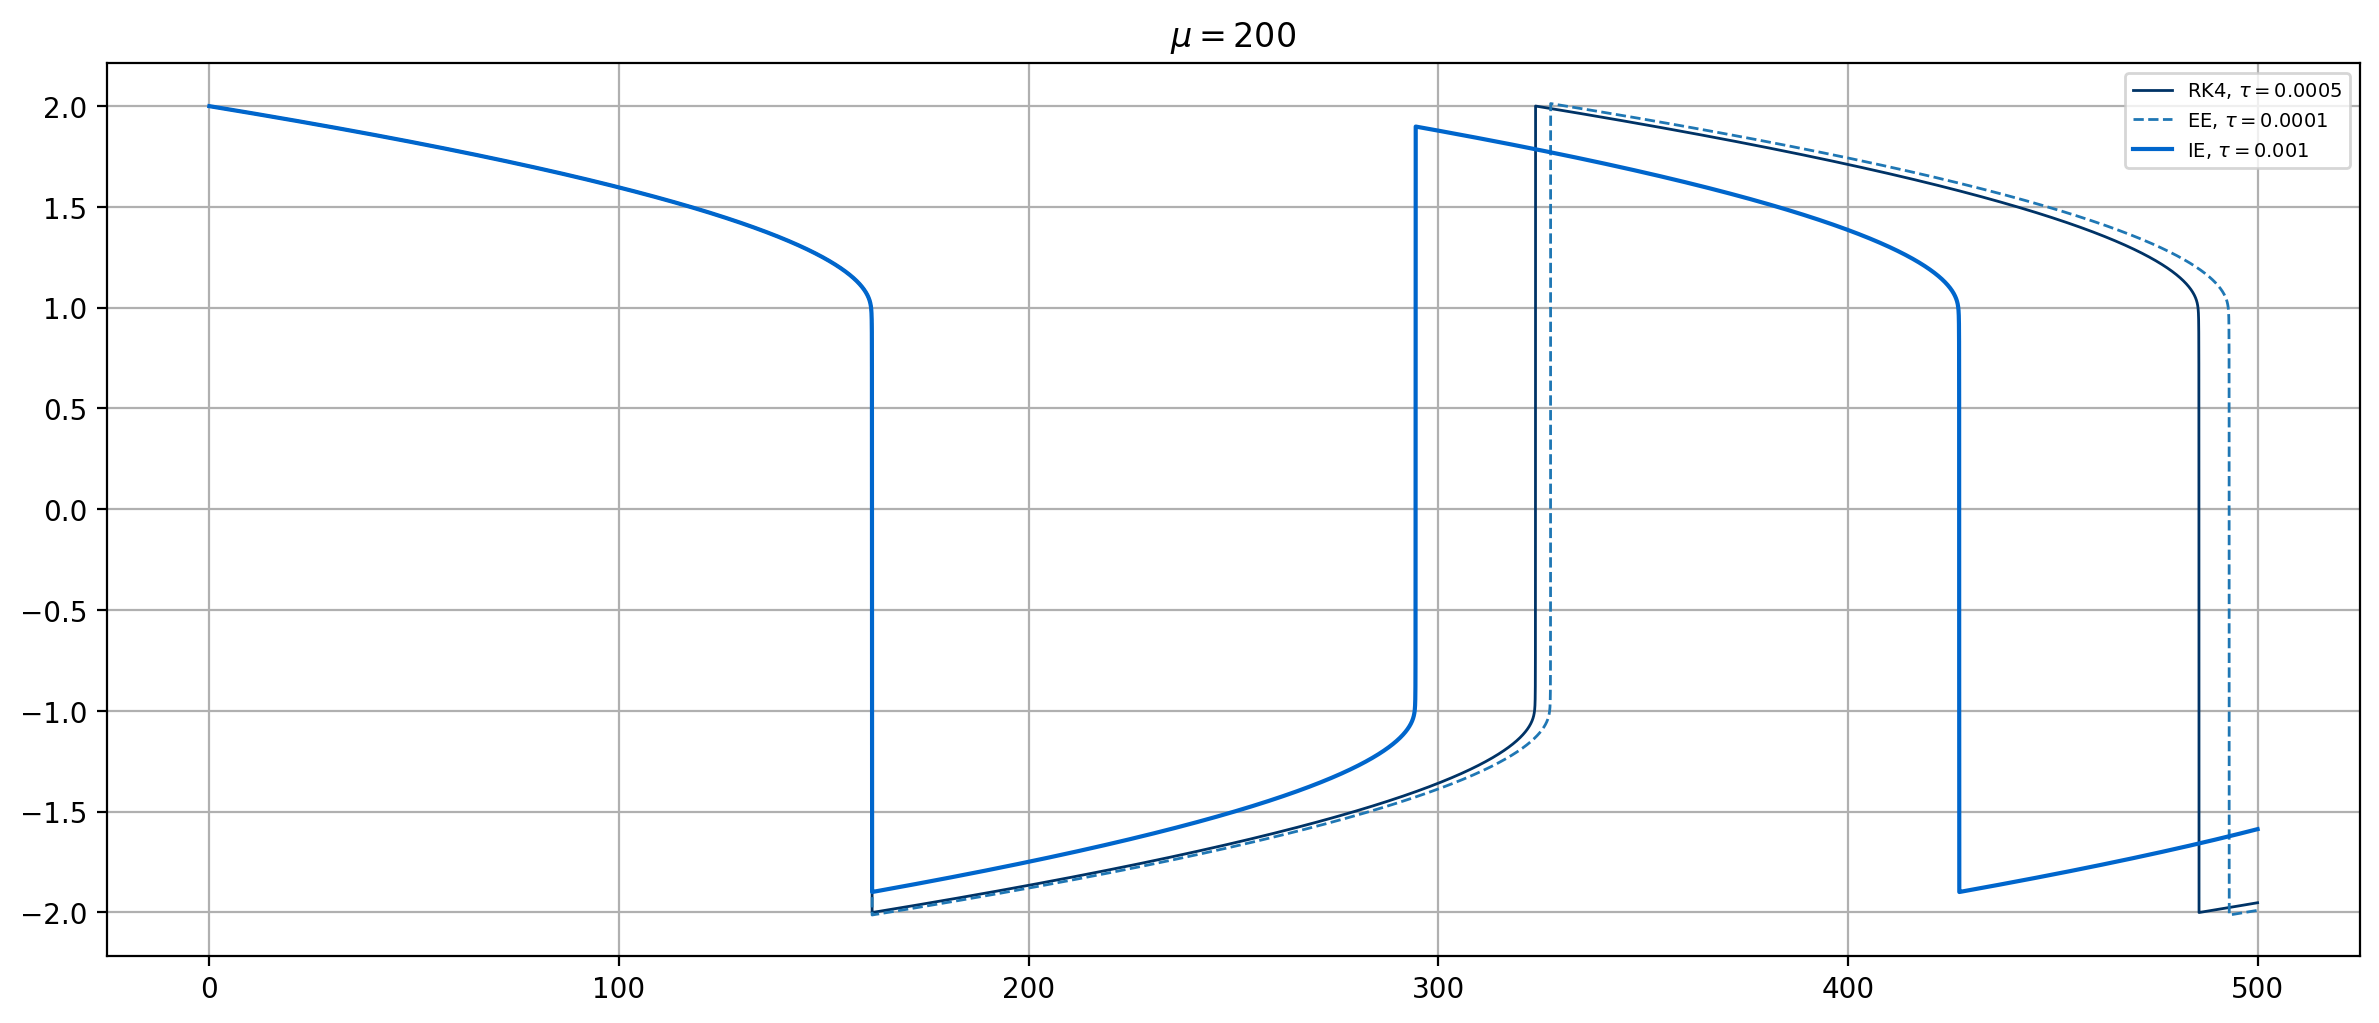

In [3]:
abra_4_3(200,0.0001,0.0005,0.001,500)

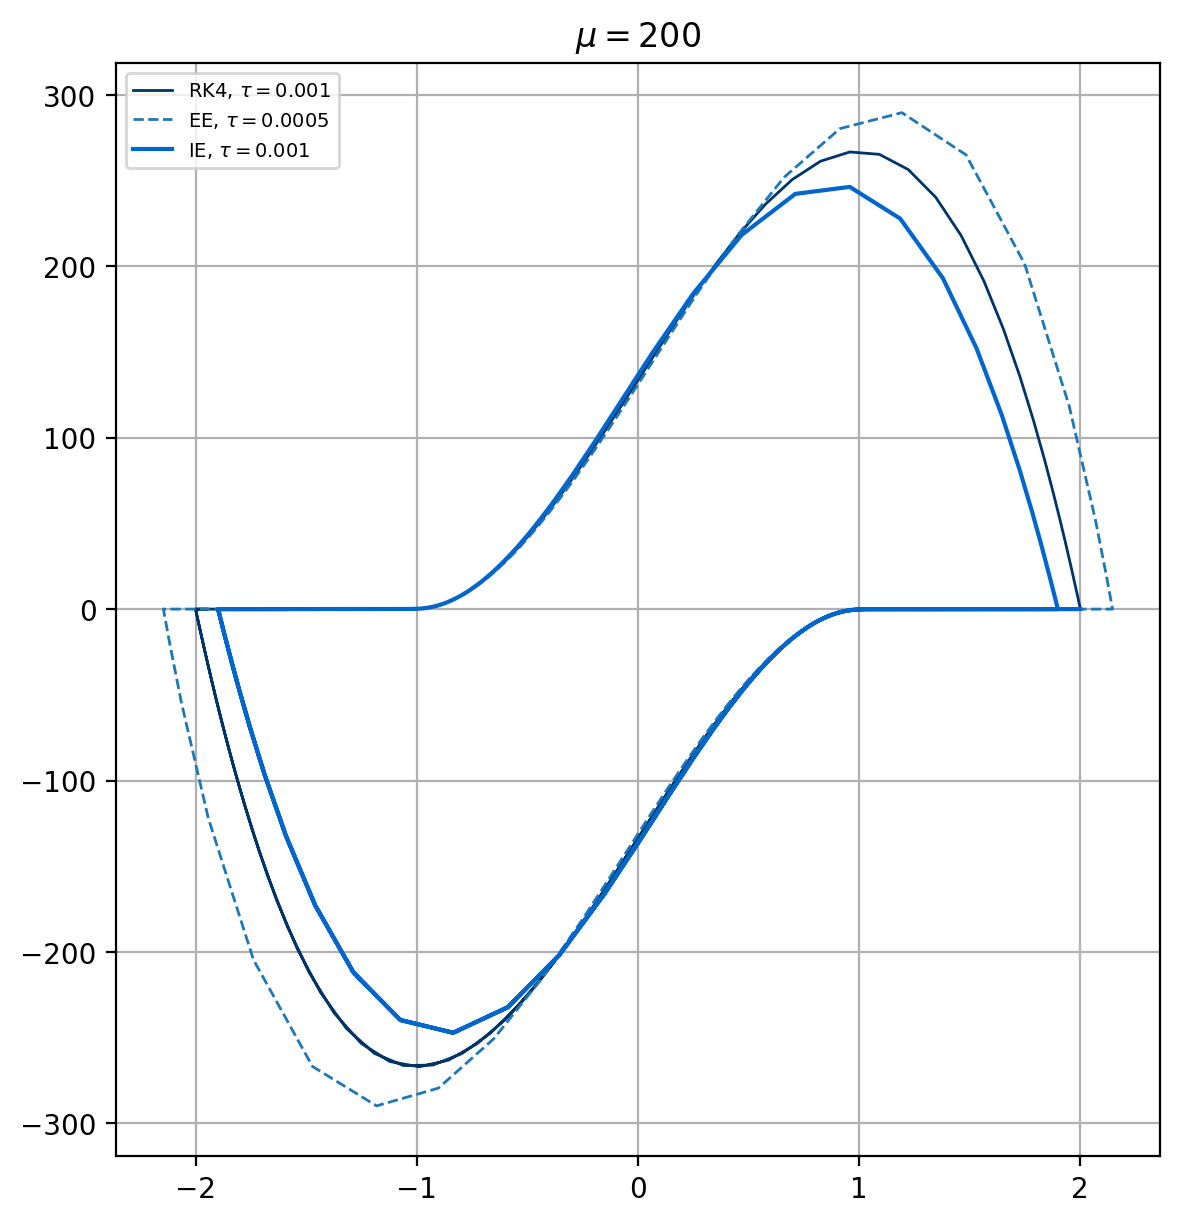

In [ ]:
abra_4_3(200,0.001,0.0005,0.001,500)

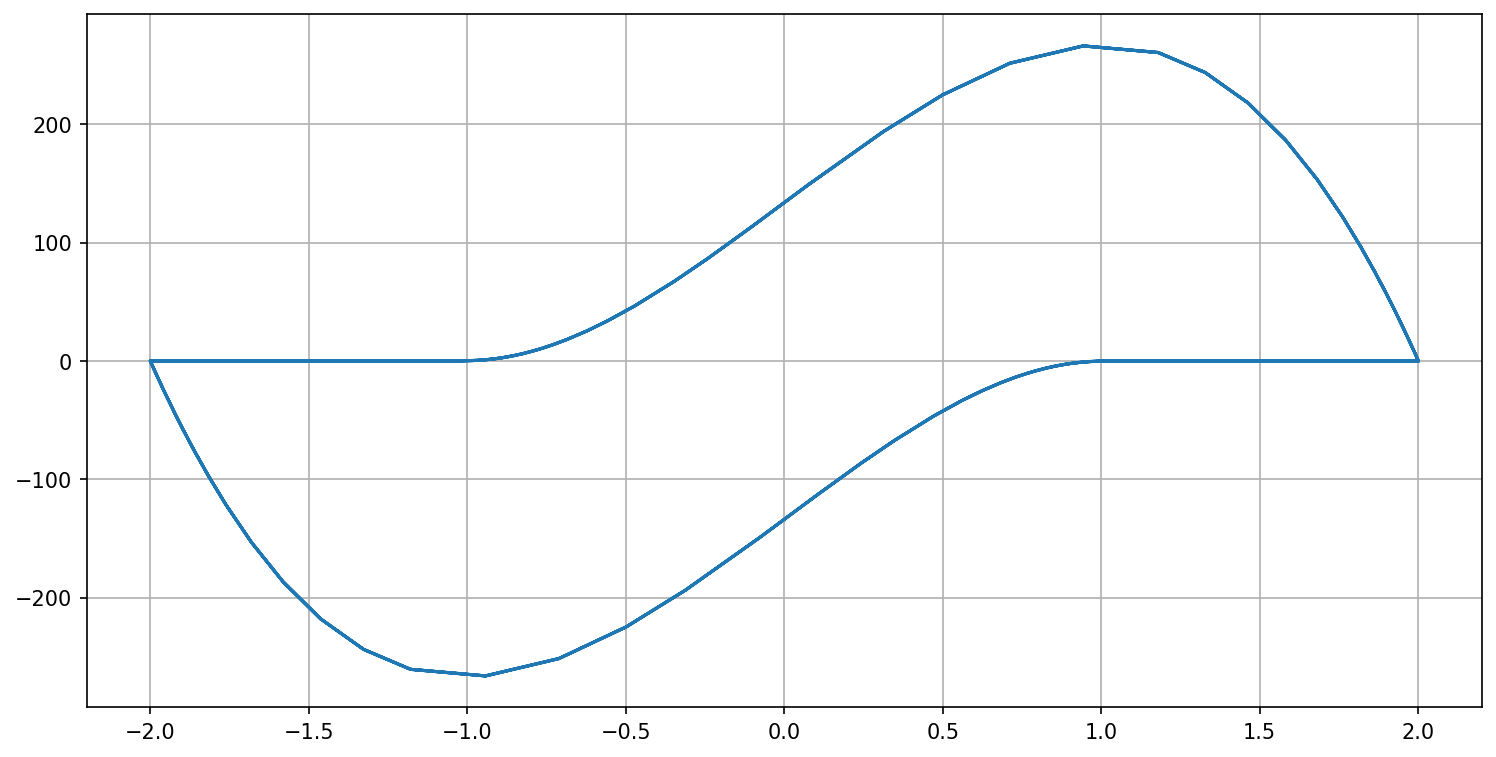

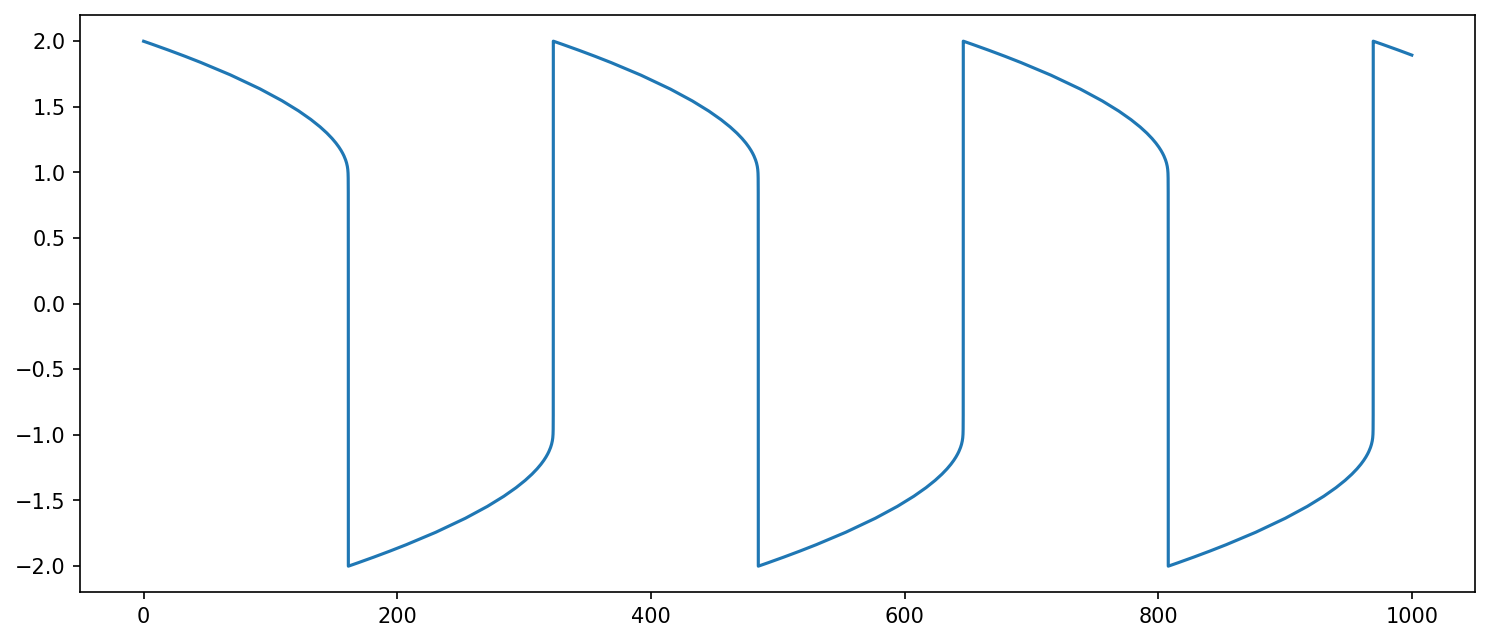

In [23]:
def aramkor(t,yn):
        return np.array([yn[1],200*(1-yn[0]**2)*yn[1]-yn[0]])

y_0=np.array([2,0])
sol=solve_ivp(aramkor,[0,1000],y_0,method="BDF")
fig, ax =plt.subplots(figsize=(12,6), dpi=150)
plt.plot(sol.y[0],sol.y[1])
plt.grid()
plt.show()
fig, ax = plt.subplots(figsize=(12,5),dpi=150)
plt.plot(sol.t,sol.y[0])
plt.show()

## Példa: Kémiai reakciók

\begin{equation}
\begin{aligned}
x'(t)&=-0.04x(t)+10^4y(t)z(t) \\
y'(t)&=0.04x(t)-10^4y(t)z(t)-3\cdot10^7y^2(t) \\
z'(t)&=3\cdot10^7y^2(t)
\end{aligned}
\end{equation}

In [11]:
def abra_5(tau1,tau2,tau,T1,T2):
    def reakcio(y):
        dx=-0.04*y[0]+10**4*y[1]*y[2]
        dy=+0.04*y[0]-10**4*y[1]*y[2]-3*10**7*(y[1]**2)
        dz=3*10**7*(y[1]**2)
        return np.array([dx,dy,dz])    
    
    def ivp_reakcio(t,y):
        dx=-0.04*y[0]+10**4*y[1]*y[2]
        dy=+0.04*y[0]-10**4*y[1]*y[2]-3*10**7*(y[1]**2)
        dz=3*10**7*(y[1]**2)
        return np.array([dx,dy,dz]) 

    def IE_reakcio(f,y,tau,t=0):
        def residual(y_new): 
            y_new = np.asarray(y_new)  
            return y_new - y - tau * f(y_new)
        
        y_guess = np.asarray(y) + tau * f(y)
        
        y_new = newton(residual, y_guess, maxiter=1000) 
        return y_new

    lepszam1=int(np.ceil(T1/tau1))
    t_ertekek1=np.array([i*tau1 for i in range(lepszam1)])
    yRK4=np.zeros((3,lepszam1))
    yRK4[:,0]=np.array([1,0,0])

    lepszam2=int(np.ceil(T1/tau2))
    t_ertekek2=np.array([i*tau2 for i in range(lepszam2)])
    yIE=np.zeros((3,lepszam2))
    yIE[:,0]=np.array([1,0,0])

    for i in range(1,lepszam1):
        k1=reakcio(yRK4[:,i-1])
        k2=reakcio(yRK4[:,i-1]+tau1*k1/2)
        k3=reakcio(yRK4[:,i-1]+tau1*k2/2)
        k4=reakcio(yRK4[:,i-1]+tau1*k3)
        yRK4[:,i]=yRK4[:,i-1]+tau1/6*(k1+2*k2+2*k3+k4)

    for i in range(1,lepszam2):
        yIE[:,i]=IE_reakcio(reakcio,yIE[:,i-1],tau2)
    
    yticks=np.arange(0.000032,0.000038,0.000001)
    fig, ax = plt.subplots(figsize=(10,5),dpi=200)
    plt.plot(t_ertekek1,yRK4[1], color="#003366", label=f"RK4, "+r"$\tau=$"+f"{tau1}")
    plt.plot(t_ertekek2,yIE[1], color="#0066CC", label=f"IE, "+r"$\tau=$"+f"{tau2}")
    plt.xlim(-0.01,0.3)
    plt.ylim(0.000032,0.000037)
    plt.legend()
    plt.xlabel(r"$t$")
    plt.ylabel(f"Koncentráció")
    #plt.grid()
    ax.set_yticks(yticks)
    ax.set_yticklabels(
    [f"{label:.6f}" for label in yticks])
    plt.show()

    lepszam3=int(np.ceil(T2/tau))
    t_ertekek3=np.array([i*tau for i in range(lepszam3)])
    yIE2=np.zeros((3,lepszam3))
    yIE2[:,0]=np.array([1,0,0])

    for i in range(1,lepszam3):
        yIE2[:,i]=IE_reakcio(reakcio,yIE2[:,i-1],tau)

    y_0=np.array([1,0,0])
    sol=solve_ivp(ivp_reakcio,[0,T2],y_0,method="BDF")

    fig, ax = plt.subplots(figsize=(10,5), dpi=200)
    plt.plot(sol.t,sol.y[0], color="#003366", alpha=0.7, label=f"Pontos")
    plt.plot(sol.t,sol.y[1]*(10**4), color="#003366", alpha=0.7)
    plt.plot(sol.t,sol.y[2], color="#003366", alpha=0.7)

    plt.plot(t_ertekek3,yIE2[0,:], color="#0066CC", linestyle="--", label=f"IE, "+r"$\tau=$"+f"{tau}")   # y értéket felszorozzuk, hogy látható legyen a többi érték mellett
    plt.plot(t_ertekek3,yIE2[1,:]*(10**4), color="#0066CC", linestyle="--")
    plt.plot(t_ertekek3,yIE2[2,:], color="#0066CC", linestyle="--")
    plt.xlabel(r"$t$")
    plt.ylabel(f"Koncentráció")
    with plt.rc_context({'mathtext.fontset': 'cm'}):
        plt.text(0.92,0.91,r"$x(t)$")
        plt.text(10**(-1.7),0.41,r"$10^4\cdot y(t)$")
        plt.text(10**(-1.6),0.02,r"$z(t)$")
    plt.grid()
    plt.xscale("log")
    plt.xlim(0,T2)
    plt.legend()
    plt.show()
    return

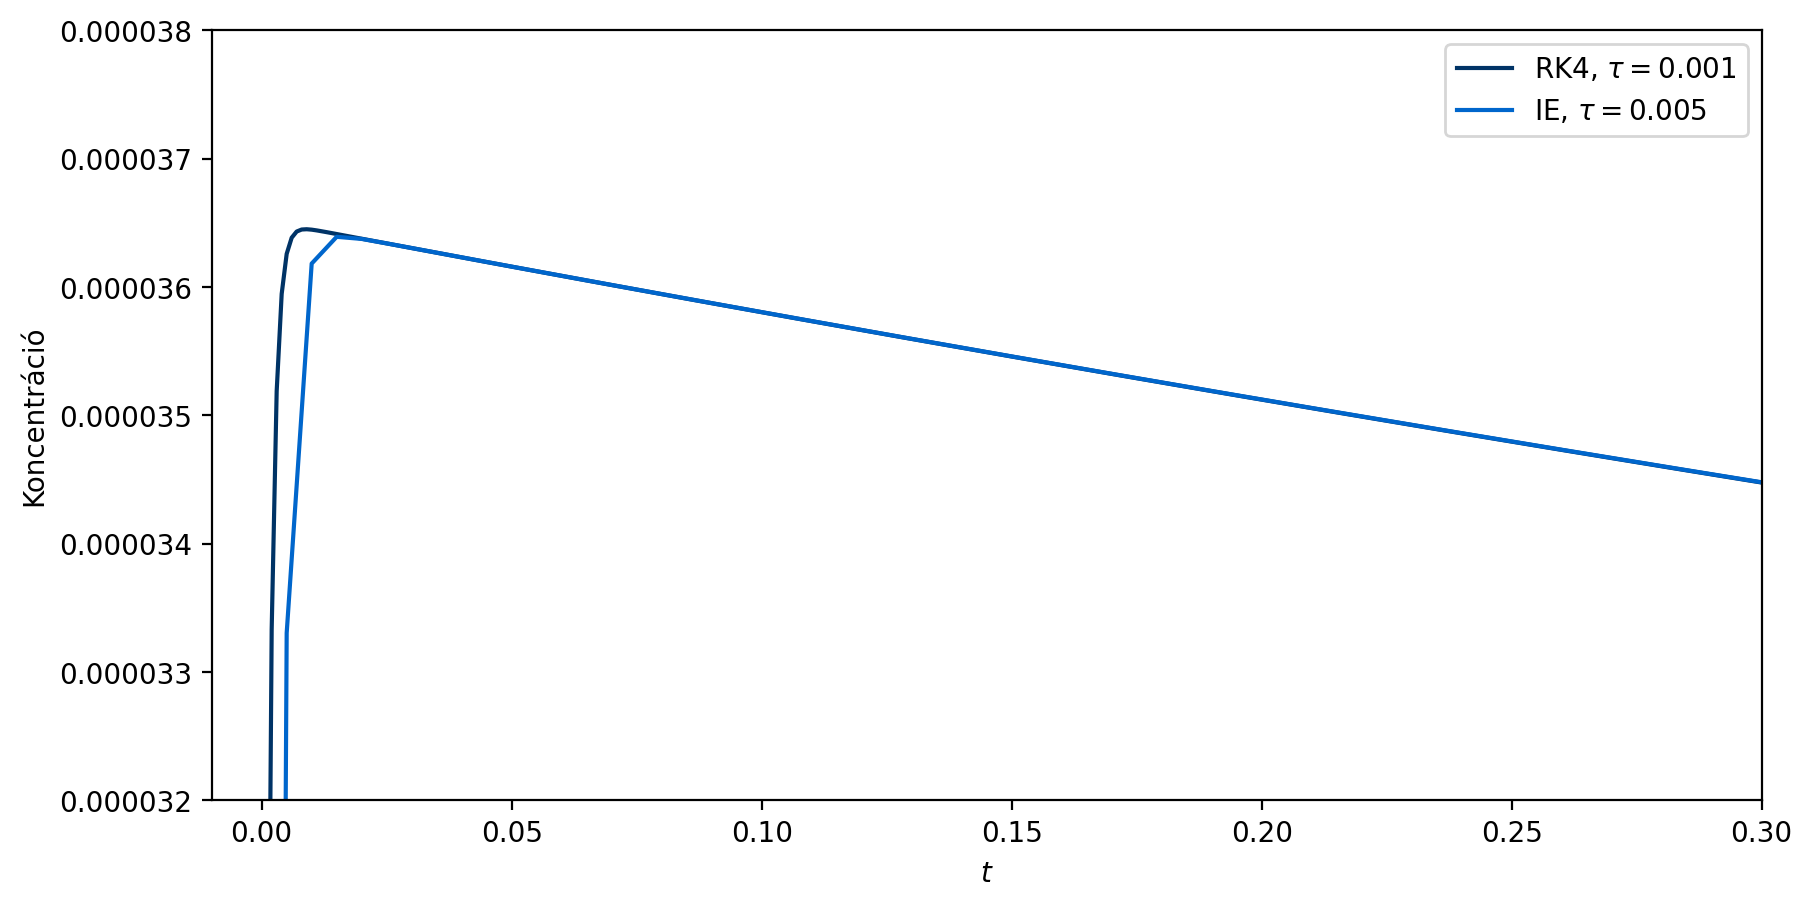

C:\Users\temes\AppData\Local\Temp\ipykernel_11560\1982825688.py:86: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,T2)
c:\Users\temes\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


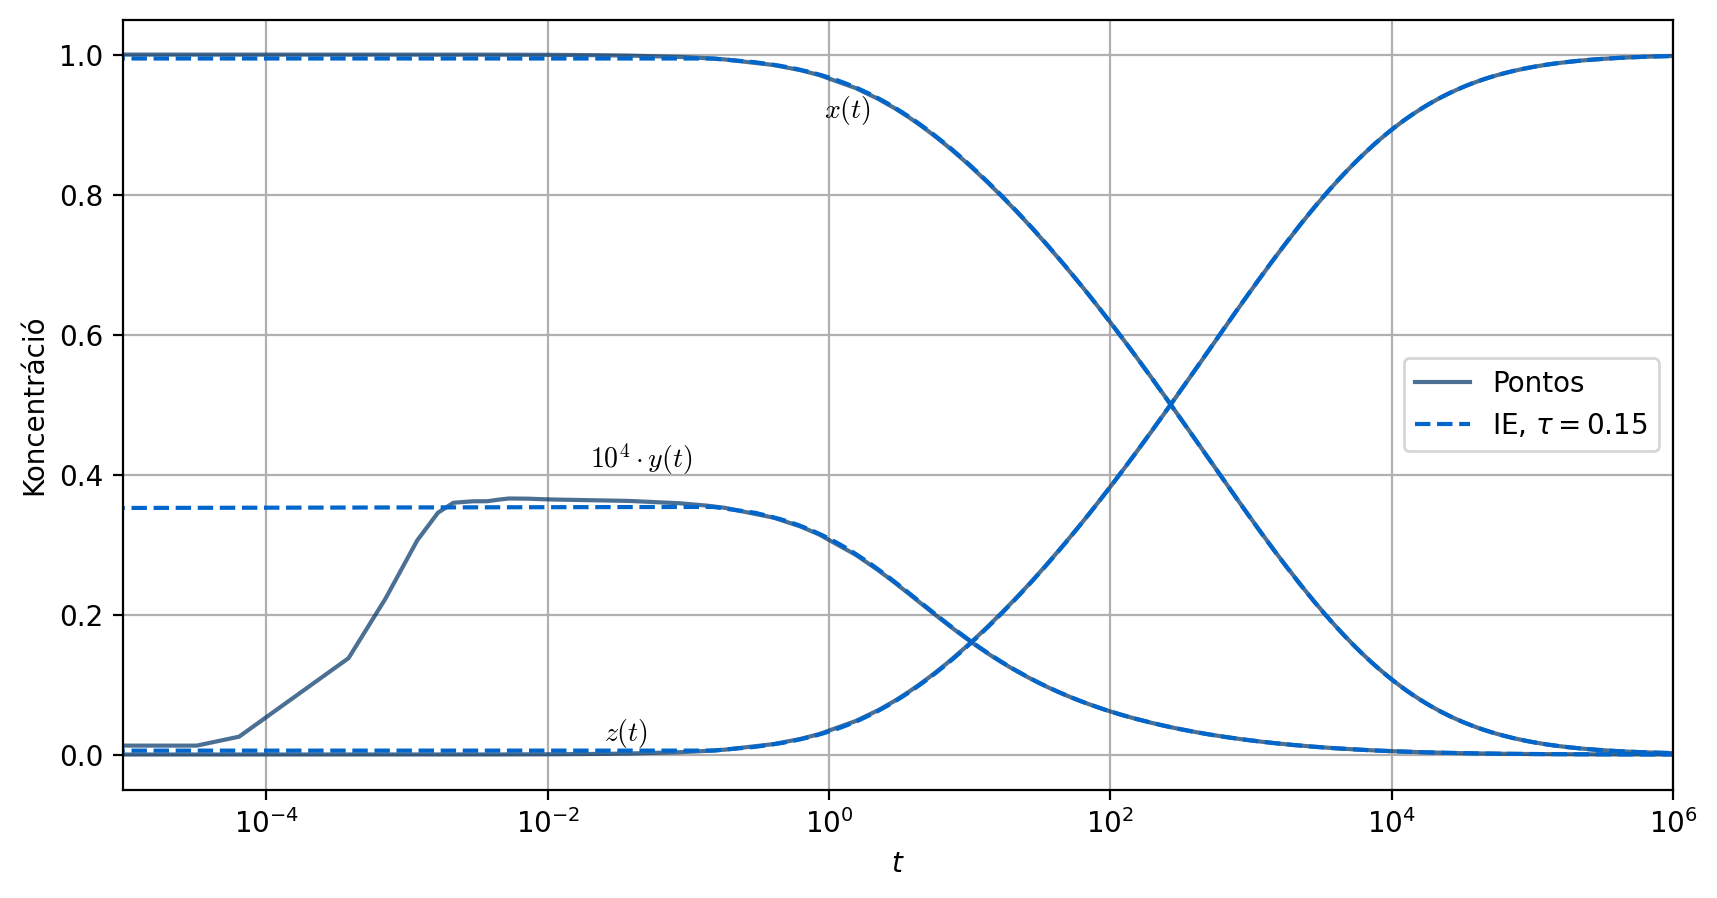

In [16]:
abra_5(0.001,0.005,0.15,3.2,10**6)

In [18]:
def reakcio(t,y):
        dx=-0.04*y[0]+10**4*y[1]*y[2]
        dy=+0.04*y[0]-10**4*y[1]*y[2]-3*10**7*(y[1]**2)
        dz=3*10**7*(y[1]**2)
        return np.array([dx,dy,dz])

y_0=np.array([1,0,0])
sol=solve_ivp(reakcio,[0,10**6],y_0,method="BDF")

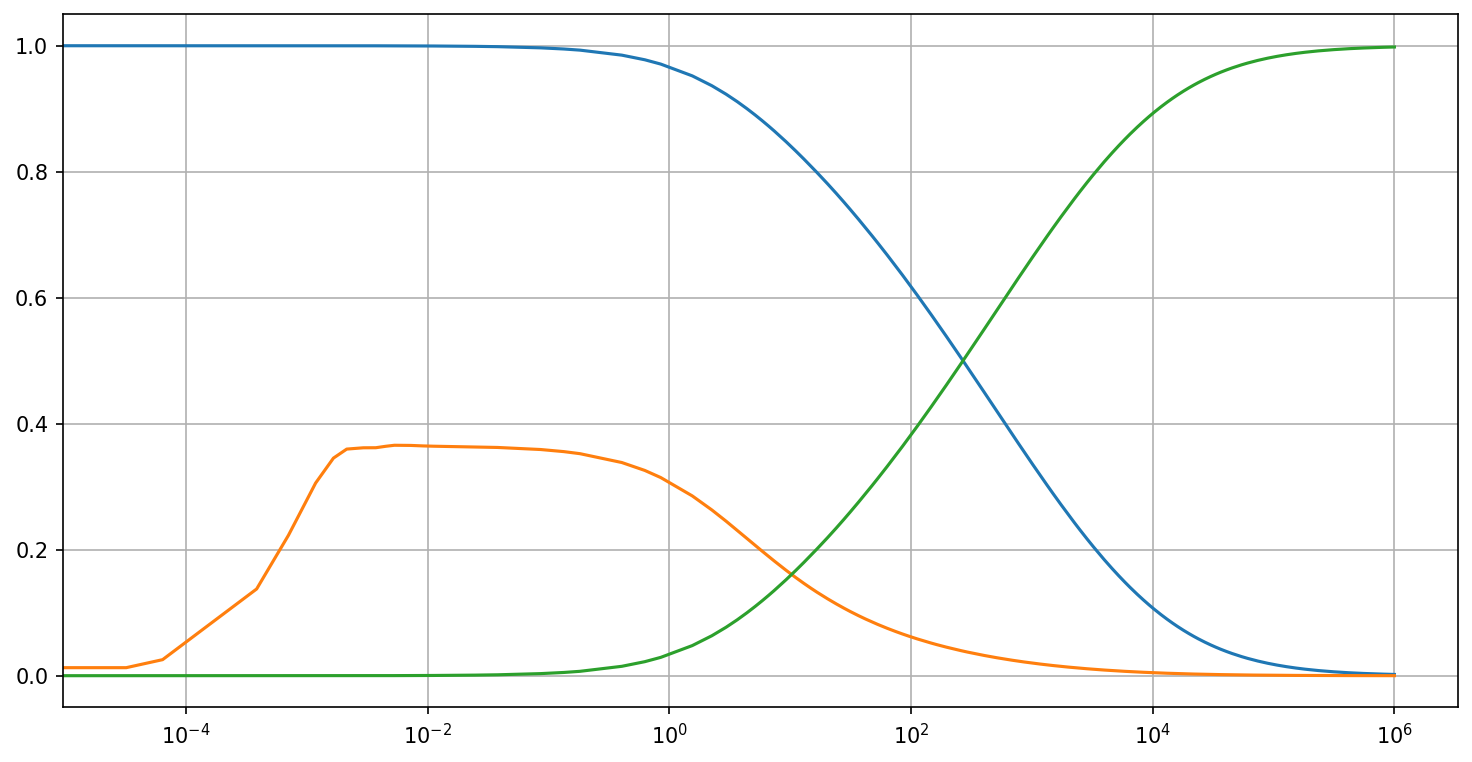

In [19]:
fig, ax =plt.subplots(figsize=(12,6), dpi=150)
plt.plot(sol.t,sol.y[0])
plt.plot(sol.t,sol.y[1]*(10**4))
plt.plot(sol.t,sol.y[2])
plt.xscale("log")
plt.grid()
plt.show()